In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

import xarray as xr

import regionmask

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import cartopy.feature as cfeat

import netCDF4

np.seterr(invalid='ignore'); # disable a warning from matplotlib and cartopy


Bad key "text.kerning_factor" on line 4 in
/home/emfreese/anaconda3/envs/conda_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


# Import data and process

In [2]:
df = pd.read_csv(f'../optimization_model/good_model_inputs/inputs_gen_normal.csv')
df.loc[df['FuelType'] == 'Pumps', 'FuelType'] = 'Hydro' #change pumps to hydro label

# Plot

## Normal

In [3]:
plants = ['NaturalGas','Coal', 'Hydro','Solar','Wind', 'Biomass', 'Nuclear'] 

fuel_type=df.loc[(df['FuelType'].isin(plants))].groupby(['ORISCode']).first()['FuelType']
color_dict = {'NaturalGas':'xkcd:light grey', 'Biomass':'xkcd:purple', 'Coal':'xkcd:chocolate brown', 
              'Hydro':'xkcd:dark blue', 'LF Gas':'xkcd:purple', 'Non-Fossil':'xkcd:pink',
       'Nuclear':'xkcd:red', 'Oil':'xkcd:dark orange', 
              'Pet. Coke':'xkcd:maroon', 'Solar':'xkcd:gold', 
              'Wind':'xkcd:pink', 'MSW':'xkcd:dark green', 
              'Fwaste':'xkcd:dust', 'Waste Coal':'xkcd:terracotta', 'Geothermal':'xkcd:dark coral'}
color_dict_short = {'NaturalGas':'xkcd:light grey blue',  'Coal':'xkcd:chocolate brown', 'Nuclear':'xkcd:red'}
color_list = [color_dict[fuel] for fuel in fuel_type]


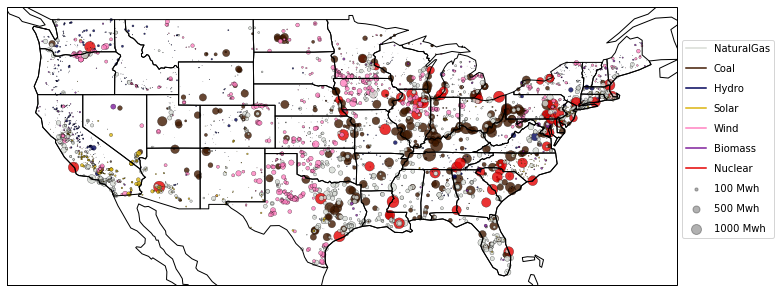

In [4]:
fig = plt.figure(figsize=[12,9])

###### Create axes ######
ax=fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeat.STATES)

###### observations #######
#create lat and lon for observations
lat_o = df.loc[(df['FuelType'].isin(plants))].groupby(['ORISCode']).first()['LAT']
lon_o = df.loc[(df['FuelType'].isin(plants))].groupby(['ORISCode']).first()['LON']
#color based on the fuel type
fuel_type=df.loc[(df['FuelType'].isin(plants))].groupby(['ORISCode']).first()['FuelType']
#size based on generation
size=df.loc[(df['FuelType'].isin(plants))].groupby(['ORISCode']).mean()['Capacity']/10
#PCM parameters and plot for observations
PCM_o=ax.scatter(lon_o, lat_o, c=color_list, s = size, transform=ccrs.PlateCarree(),linewidth=.3, marker = 'o', edgecolor = 'k', 
                  alpha = 0.8)
for key in plants:
    plt.plot([],[],label=key, color=color_dict[key])
plt.legend();

for size in [10, 50, 100]:
    plt.scatter([], [], c='k', alpha=0.3, s=size,
                label=str(size*10) + ' Mwh')
plt.legend(scatterpoints=1, frameon=True, labelspacing=1, bbox_to_anchor = (1.0,.9))

plt.savefig('./Figures/plants_normal.png', bbox_inches = 'tight', dpi = 150)

## No Nuclear

In [5]:
plants = ['NaturalGas','Coal', 'Hydro','Solar','Wind', 'Biomass']

fuel_type=df.loc[(df['FuelType'].isin(plants))].groupby(['ORISCode']).first()['FuelType']
color_dict = {'NaturalGas':'xkcd:light grey', 'Biomass':'xkcd:purple', 'Coal':'xkcd:chocolate brown', 
              'Hydro':'xkcd:dark blue', 'LF Gas':'xkcd:purple', 'Non-Fossil':'xkcd:pink',
       'Nuclear':'xkcd:red', 'Oil':'xkcd:dark orange', 
              'Pet. Coke':'xkcd:maroon', 'Solar':'xkcd:gold', 
              'Wind':'xkcd:pink', 'MSW':'xkcd:dark green', 
              'Fwaste':'xkcd:dust', 'Waste Coal':'xkcd:terracotta', 'Geothermal':'xkcd:dark coral'}
color_dict_short = {'NaturalGas':'xkcd:light grey blue',  'Coal':'xkcd:chocolate brown', 'Nuclear':'xkcd:red'}
color_list = [color_dict[fuel] for fuel in fuel_type]


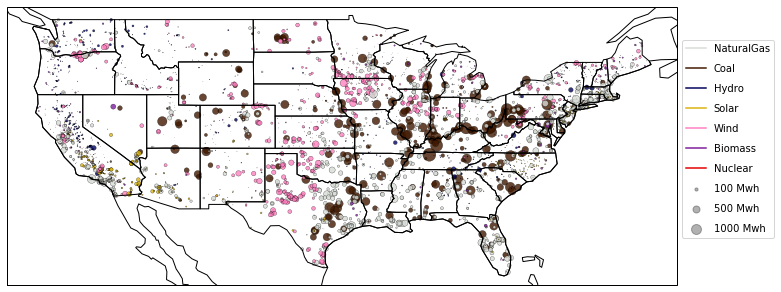

In [6]:
fig = plt.figure(figsize=[12,9])

###### Create axes ######
ax=fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeat.STATES)

###### observations #######
#create lat and lon for observations
lat_o = df.loc[(df['FuelType'].isin(plants))].groupby(['ORISCode']).first()['LAT']
lon_o = df.loc[(df['FuelType'].isin(plants))].groupby(['ORISCode']).first()['LON']
#color based on the fuel type
fuel_type=df.loc[(df['FuelType'].isin(plants))].groupby(['ORISCode']).first()['FuelType']
#size based on generation
size=df.loc[(df['FuelType'].isin(plants))].groupby(['ORISCode']).mean()['Capacity']/10
#PCM parameters and plot for observations
PCM_o=ax.scatter(lon_o, lat_o, c=color_list, s = size, transform=ccrs.PlateCarree(),linewidth=.3, marker = 'o', edgecolor = 'k', 
                  alpha = 0.8)
plants = ['NaturalGas','Coal', 'Hydro','Solar','Wind', 'Biomass', 'Nuclear'] 

for key in plants:
    plt.plot([],[],label=key, color=color_dict[key])
plt.legend();

for size in [10, 50, 100]:
    plt.scatter([], [], c='k', alpha=0.3, s=size,
                label=str(size*10) + ' Mwh')
plt.legend(scatterpoints=1, frameon=True, labelspacing=1, bbox_to_anchor = (1.0,.9))

plt.savefig('./Figures/plants_nonuc.png', bbox_inches = 'tight', dpi = 150)